# [Forecasting With Machine Learning](https://www.kaggle.com/code/ryanholbrook/forecasting-with-machine-learning)

## Introduction
In Lessons 2 and 3, we create a simple regression from a single input, the time index. We could easily create forecasts for any time in the future by just generating our desired trend and seasonal features.

In Lesson 4, we create Lag features. A lag 1 feature shifts the time series 1 step, which means you could forecast 1 step into the future but not 2 steps. 

Assuming we could always generate lags up to the period we wanted to forecast, real-world forecasting typically demands more than this. So in this lesson we'll learn how to make forecasts for a variety of situations.

## Defining a forecast

Things to know before designing a forecasting model:

* what information is available at the time a forecast is made (**features**), and,
* the time period during which you require forecasted values (**target**).

To be specific:
1. **Forecast origin**
   * It's the starting point from which the forecasted values are projected into the future.
   * For instance, if you have some historical data and plan to predict future values for the next month, the forecast origin would be the last known data point in the historical data. From this point onward, you project future values based on your forecasting model.
   * Everything up to the origin can be used to create `features`.
2. **Forecast horizon**
   * It is the length of time into the future for which predictions are made.
   * For example, if you want to predict sales for the next 12 months, then the forecast horizon would be 12 months.
   * We often describe a forecast by the number of time steps: a "1-step" forecast or "5-step" forecast. 
   * The forecast horizon describes the `target`.
3. **Lead time (or latency)**
   * It it the duration between the forecast origin and the forecast horizon.

The figure below represents a two-step `forecast horizon` with a two-step `lead time`, using four lag features.

![forecast_terms.png](image/forecast_terms.png)

## Preparing Data for Forecasting

For multistep forecasts, a model has to produce multiple outputs, one for each step. See an example below:

In [10]:
import numpy as np
import pandas as pd

import warnings
# warnings.simplefilter(action='ignore', category=FutureWarning)
warnings.filterwarnings('ignore')

N = 20
ts = pd.Series(
    np.arange(N),
    index=pd.period_range(start='2010', freq='Y', periods=N, name='Year'),
    dtype=pd.Int8Dtype,
)

# Lag features
X = pd.DataFrame({
    'y_lag_2': ts.shift(2),
    'y_lag_3': ts.shift(3),
    'y_lag_4': ts.shift(4),
    'y_lag_5': ts.shift(5),
    'y_lag_6': ts.shift(6),    
})

# Multistep targets
y = pd.DataFrame({
    'y_step_3': ts.shift(-2),
    'y_step_2': ts.shift(-1),
    'y_step_1': ts,
})

data = pd.concat({'Targets': y, 'Features': X}, axis=1)

data.head(10).style.set_properties(['Targets'], **{'background-color': 'LavenderBlush'}) \
                   .set_properties(['Features'], **{'background-color': 'Lavender'})

The above illustrates a dataset:
* Forecast origin = `y_step_1`<br>
  The missing values we could either fill-in or drop.
* Five lag features:<br>
  It can do a task of a three-step `forecasting` with a two-step `lead time`.

## Example - Flu Trends

### Load data
Define plot function 'plot_multistep()' and load flu-trends data

In [19]:
from pathlib import Path
from warnings import simplefilter

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
from sklearn.linear_model import LinearRegression
from sklearn.metrics import root_mean_squared_error
from sklearn.model_selection import train_test_split
from xgboost import XGBRegressor

simplefilter("ignore")

# Set Matplotlib defaults
# plt.style.use("seaborn-whitegrid")
plt.rc("figure", autolayout=True, figsize=(11, 4))
plt.rc(
    "axes",
    labelweight="bold",
    labelsize="large",
    titleweight="bold",
    titlesize=16,
    titlepad=10,
)
plot_params = dict(
    color="0.75",
    style=".-",
    markeredgecolor="0.25",
    markerfacecolor="0.25",
)
%config InlineBackend.figure_format = 'retina'


def plot_multistep(y, every=1, ax=None, palette_kwargs=None):
    palette_kwargs_ = dict(palette='husl', n_colors=16, desat=None)
    if palette_kwargs is not None:
        palette_kwargs_.update(palette_kwargs)
    palette = sns.color_palette(**palette_kwargs_)
    if ax is None:
        fig, ax = plt.subplots()
    ax.set_prop_cycle(plt.cycler('color', palette))
    for date, preds in y[::every].iterrows():
        preds.index = pd.period_range(start=date, periods=len(preds))
        preds.plot(ax=ax)
    return ax


In [ ]:
# load data
flu_trends = pd.read_csv("data/flu-trends.csv")
flu_trends.set_index(
    pd.PeriodIndex(flu_trends.Week, freq="W"),
    inplace=True,
)
flu_trends.drop("Week", axis=1, inplace=True)

First, prepare **target** series (weekly office visits for the flu) for multi-step forecasting.

In [14]:
def make_lags(ts, lags, lead_time=1):
    return pd.concat(
        {
            f'y_lag_{i}': ts.shift(i)
            for i in range(lead_time, lags + lead_time)
        },
        axis=1)


# Four weeks of lag features
y = flu_trends.FluVisits.copy()
X = make_lags(y, lags=4).fillna(0.0)


def make_multistep_target(ts, steps):
    return pd.concat(
        {f'y_step_{i + 1}': ts.shift(-i)
         for i in range(steps)},
        axis=1)


# Eight-week forecast
y = make_multistep_target(y, steps=8).dropna()

# Shifting has created indexes that don't match. Only keep times for
# which we have both targets and features.
y, X = y.align(X, join='inner', axis=0)

print("features: X\n-----------------")
display(X.head())

print("\ntargets: y\n-----------------")
display(y.head())


features: X
-----------------


,y_lag_1,y_lag_2,y_lag_3,y_lag_4
Week,,,,
2009-06-29/2009-07-05,0.0,0.0,0.0,0.0
2009-07-06/2009-07-12,180.0,0.0,0.0,0.0
2009-07-13/2009-07-19,115.0,180.0,0.0,0.0
2009-07-20/2009-07-26,132.0,115.0,180.0,0.0
2009-07-27/2009-08-02,109.0,132.0,115.0,180.0



targets: y
-----------------


,y_step_1,y_step_2,y_step_3,y_step_4,y_step_5,y_step_6,y_step_7,y_step_8
Week,,,,,,,,
2009-06-29/2009-07-05,180,115.0,132.0,109.0,120.0,115.0,123.0,205.0
2009-07-06/2009-07-12,115,132.0,109.0,120.0,115.0,123.0,205.0,454.0
2009-07-13/2009-07-19,132,109.0,120.0,115.0,123.0,205.0,454.0,628.0
2009-07-20/2009-07-26,109,120.0,115.0,123.0,205.0,454.0,628.0,687.0
2009-07-27/2009-08-02,120,115.0,123.0,205.0,454.0,628.0,687.0,821.0


### Multi-output model

There are 269 weeks in the training set and 90 weeks in the test set, and we now have an 8-step forecast for each of these weeks.

In [21]:
# Create splits
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, shuffle=False)

# Use linear regression create multi-outputs
model = LinearRegression()
model.fit(X_train, y_train)

# train and test
y_fit = pd.DataFrame(model.predict(X_train), index=X_train.index, columns=y.columns)
y_pred = pd.DataFrame(model.predict(X_test), index=X_test.index, columns=y.columns)

## root mean sqare error
train_rmse = root_mean_squared_error(y_train, y_fit)
test_rmse = root_mean_squared_error(y_test, y_pred)

print((f"Train RMSE: {train_rmse:.2f}\n" f"Test RMSE: {test_rmse:.2f}"))


Train RMSE: 389.12
Test RMSE: 582.33


Plot

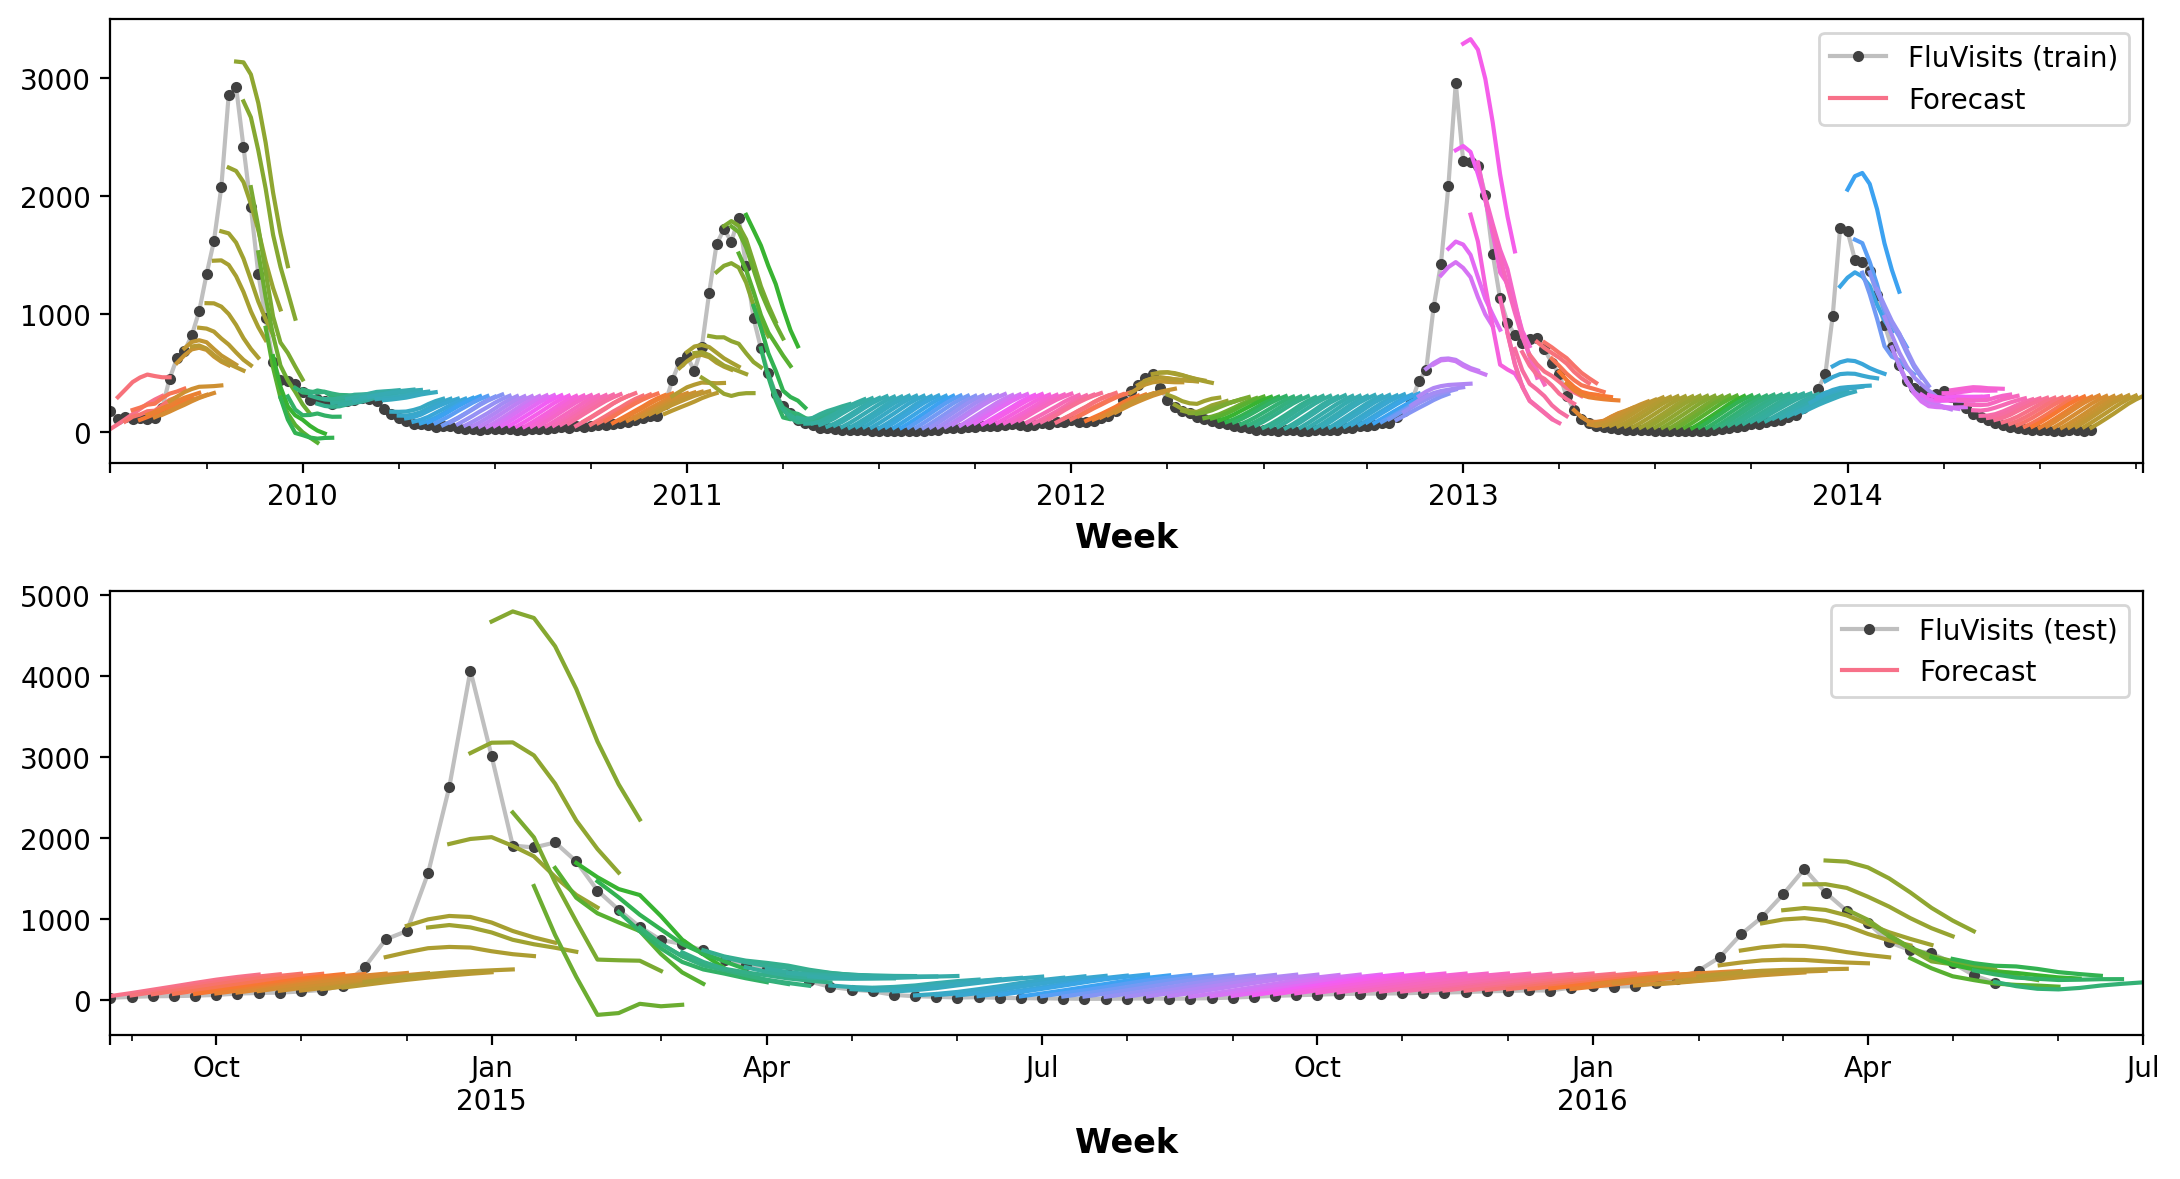

In [27]:
palette = dict(palette='husl', n_colors=64)

# y_fit
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(11, 6))
ax1 = flu_trends.FluVisits[y_fit.index].plot(**plot_params, ax=ax1)
ax1 = plot_multistep(y_fit, ax=ax1, palette_kwargs=palette)
_ = ax1.legend(['FluVisits (train)', 'Forecast'])

# y_pred
ax2 = flu_trends.FluVisits[y_pred.index].plot(**plot_params, ax=ax2)
ax2 = plot_multistep(y_pred, ax=ax2, palette_kwargs=palette)
_ = ax2.legend(['FluVisits (test)', 'Forecast'])

### Direct strategy
